In [1]:
from IPython.core.display import display, HTML
import math
import pandas as pd

import mlos.global_values as global_values
from mlos.Optimizers.BayesianOptimizerFactory import BayesianOptimizerFactory
from mlos.Optimizers.BayesianOptimizerConfigStore import bayesian_optimizer_config_store
from mlos.Optimizers.OptimizationProblem import OptimizationProblem, Objective
from mlos.Spaces import ContinuousDimension, Point, SimpleHypergrid
from mlos.Tracer import Tracer

display(HTML("<style>.container { width:100% !important; }</style>"))

global_values.declare_singletons()
global_values.tracer = Tracer(actor_id="MetaOptimizer", thread_id=0)

# Let's stand up the Optimizer Microservice
#
optimizer_factory = BayesianOptimizerFactory()

In [2]:
# Let's make a meta optimizer.
#
meta_optimizer_config = bayesian_optimizer_config_store.get_config_by_name("default_with_glow_worm")
meta_optimizer_config.homogeneous_random_forest_regression_model_config.n_estimators = 100
meta_optimizer_config.homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.n_new_samples_before_refit = 1
meta_optimizer_config.experiment_designer_config.fraction_random_suggestions = 0.2

meta_optimizer = optimizer_factory.create_local_optimizer(
    optimizer_config=meta_optimizer_config,
    optimization_problem=OptimizationProblem(
        parameter_space=bayesian_optimizer_config_store.parameter_space,
        objective_space=SimpleHypergrid(
            name="predictions",
            dimensions=[
                ContinuousDimension(name="optimum_value_after_100_iterations", min=-math.inf, max=math.inf)
            ]
        ),
        objectives=[Objective(name='optimum_value_after_100_iterations', minimize=True)]
    )
)

09/29/2020 19:08:40 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizerFactory.py:  40 -    create_local_optimizer() ] Creating a bayesian optimizer with config: {
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 10,
  "homogeneous_random_forest_regression_model_config.n_estimators": 100,
  "homogeneous_random_forest_regression_model_config.features_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.samples_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.regressor_implementation": "DecisionTreeRegressionModel",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.criterion": "mse",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.splitter": "best",
  "homogeneous_random_forest_regression_mo

In [3]:
from mlos.OptimizerEvaluationTools.ObjectiveFunctionFactory import ObjectiveFunctionFactory
from mlos.OptimizerEvaluationTools.ObjectiveFunctionConfigStore import objective_function_config_store
objective_function_config = objective_function_config_store.get_config_by_name('three_level_quadratic')
objective_function = ObjectiveFunctionFactory.create_objective_function(objective_function_config)

print(objective_function_config.to_json(indent=2))

{
  "implementation": "ThreeLevelQuadratic"
}


In [4]:
print(objective_function.parameter_space)

  Name: three_level_quadratic_config
  Dimensions:
    vertex_height: {low, 5, 15}

  IF vertex_height IN {15} THEN (
    Name: high_quadratic_params
    Dimensions:
      x_1: [-100.00, 100.00]
      x_2: [-100.00, 100.00]
  )

  IF vertex_height IN {5} THEN (
    Name: medium_quadratic_params
    Dimensions:
      x_1: [-100.00, 100.00]
      x_2: [-100.00, 100.00]
  )

  IF vertex_height IN {low} THEN (
    Name: low_quadratic_params
    Dimensions:
      x_1: [-100.00, 100.00]
      x_2: [-100.00, 100.00]
  )


In [5]:
from mlos.Logger import create_logger
from mlos.Optimizers.RegressionModels.RegressionModelFitState import RegressionModelFitState

# Let us set up the lists to track optima over time.
#
best_observation_num_observations = []
best_observation_configs = []
best_observations = []

predicted_value_num_observations = []
best_predicted_value_configs = []
best_predicted_values = []

regression_model_fit_state = RegressionModelFitState()

In [6]:
logger = create_logger("Optimizer evaluation.")
outer_loop_iteration = 0

In [ ]:
from mlos.Optimizers.OptimumDefinition import OptimumDefinition
from mlos.Optimizers.RegressionModels.GoodnessOfFitMetrics import GoodnessOfFitMetrics, DataSetType



start_iteration_num = outer_loop_iteration
end_iteration_num = start_iteration_num + 50

for outer_loop_iteration in range(start_iteration_num, end_iteration_num):
    inner_optimizer_config = meta_optimizer.suggest()
    
    inner_optimizer = optimizer_factory.create_local_optimizer(
        optimizer_config=inner_optimizer_config,
        optimization_problem=OptimizationProblem(
            parameter_space=objective_function.parameter_space,
            objective_space=objective_function.output_space,
            objectives=[Objective(name='y', minimize=True)]
        )
    )
    
    ############################################# INNER OPTIMIZATION #############################################
    
    try:
        for i in range(100):
            parameters = inner_optimizer.suggest()
            objectives = objective_function.evaluate_point(parameters)
            logger.info(f"[{i+1}/{100}]Parameters: {parameters}, objectives: {objectives}")
            inner_optimizer.register(feature_values_pandas_frame=parameters.to_dataframe(), target_values_pandas_frame=objectives.to_dataframe())
        best_observation_config, best_observation = inner_optimizer.optimum(OptimumDefinition.BEST_OBSERVATION)
        
        logger.info(f"[{outer_loop_iteration+1}/{end_iteration_num}] {best_observation}")
        meta_optimizer.register(feature_values_pandas_frame=inner_optimizer_config.to_dataframe(), target_values_pandas_frame=Point(optimum_value_after_100_iterations=best_observation.y).to_dataframe())
    
    except:
        logger.error("Failed to complete inner optimization.", exc_info=True)
    
    ############################################# INNER OPTIMIZATION #############################################
    
    
    if meta_optimizer.trained:
        gof_metrics = meta_optimizer.compute_surrogate_model_goodness_of_fit()
        regression_model_fit_state.set_gof_metrics(data_set_type=DataSetType.TRAIN, gof_metrics=gof_metrics)
        
    best_observation_num_observations.append(outer_loop_iteration)
    
    best_observation_config, best_observation = meta_optimizer.optimum(OptimumDefinition.BEST_OBSERVATION)    
    best_observation_configs.append(best_observation_config)
    best_observations.append(best_observation)
    
    try:
        best_predicted_value_config, best_predicted_value = meta_optimizer.optimum(OptimumDefinition.PREDICTED_VALUE_FOR_OBSERVED_CONFIG)
        best_predicted_value_configs.append(best_predicted_value_config)
        best_predicted_values.append(best_predicted_value)
        predicted_value_num_observations.append(outer_loop_iteration)
    except:
        pass
    

09/29/2020 19:54:05 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizerFactory.py:  40 -    create_local_optimizer() ] Creating a bayesian optimizer with config: {
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 34,
  "homogeneous_random_forest_regression_model_config.n_estimators": 44,
  "homogeneous_random_forest_regression_model_config.features_fraction_per_estimator": 0.9239944243378945,
  "homogeneous_random_forest_regression_model_config.samples_fraction_per_estimator": 0.07122207587986584,
  "homogeneous_random_forest_regression_model_config.regressor_implementation": "DecisionTreeRegressionModel",
  "homogeneous_random_forest_regression_model_config.bootstrap": 0,
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.criterion": "friedman_mse",
  "homogeneous_random_forest_regression_m

09/29/2020 19:54:05 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [19/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": 5.6983818620028615, "medium_quadratic_params.x_2": 11.615315087705994}, objectives: {"y": 172.3871004318937}
09/29/2020 19:54:05 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [20/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": -48.47481535516427, "low_quadratic_params.x_2": 5.64733957993073}, objectives: {"y": 2381.7001680483213}
09/29/2020 19:54:05 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [21/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": -92.23339965370612, "medium_quadratic_params.x_2": -27.07052329814323}, objectives: {"y": 9244.81324331559}
09/29/2020 19:54:05 -      Optimizer evaluation. -    INFO - [<ipyth

09/29/2020 19:54:06 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [46/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": 67.24703479249854, "high_quadratic_params.x_2": 60.506605111705994}, objectives: {"y": 8198.212950527435}
09/29/2020 19:54:06 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [47/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": -10.010434624591795, "low_quadratic_params.x_2": 68.88810569702059}, objectives: {"y": 4845.7799078971075}
09/29/2020 19:54:06 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [48/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": -66.17859448543567, "high_quadratic_params.x_2": 14.741934428799254}, objectives: {"y": 4611.930998770753}
09/29/2020 19:54:06 -      Optimizer evaluation. -    INFO - [<ipython-i

09/29/2020 19:54:11 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [73/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": 38.366461356861976, "medium_quadratic_params.x_2": -18.829520316950948}, objectives: {"y": 1831.5361924140516}
09/29/2020 19:54:11 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [74/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": -47.399047057326584, "medium_quadratic_params.x_2": 85.49657086085566}, objectives: {"y": 9561.333290907973}
09/29/2020 19:54:12 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [75/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": -29.765061839969093, "medium_quadratic_params.x_2": 75.82272317113515}, objectives: {"y": 6640.04425542378}
09/29/2020 19:54:12 -      Optimizer evaluation. -    INFO - [<

09/29/2020 19:54:16 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [100/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": 68.63281158424223, "low_quadratic_params.x_2": 8.010886660631328}, objectives: {"y": 4774.637131047576}
09/29/2020 19:54:16 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  31 -                  <module>() ] [50/99] {"y": 144.03429896096296}
09/29/2020 19:54:47 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizerFactory.py:  40 -    create_local_optimizer() ] Creating a bayesian optimizer with config: {
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 86,
  "homogeneous_random_forest_regression_model_config.n_estimators": 65,
  "homogeneous_random_forest_regression_model_config.features_fraction_per_esti

09/29/2020 19:54:47 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [17/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": 67.09465859903162, "medium_quadratic_params.x_2": 96.43771742647004}, objectives: {"y": 13806.926554948292}
09/29/2020 19:54:47 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [18/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": -20.35655095100546, "medium_quadratic_params.x_2": 99.85086605577158}, objectives: {"y": 10389.584618708519}
09/29/2020 19:54:47 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [19/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": -48.08505795139466, "high_quadratic_params.x_2": 47.10216778400553}, objectives: {"y": 4545.787008141591}
09/29/2020 19:54:47 -      Optimizer evaluation. -    INFO - [<ipytho

09/29/2020 19:54:48 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [44/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": 47.19704164203634, "medium_quadratic_params.x_2": 92.34313796364702}, objectives: {"y": 10759.815868733262}
09/29/2020 19:54:48 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [45/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": 64.76737523552393, "low_quadratic_params.x_2": 26.695850726710574}, objectives: {"y": 4907.481340921971}
09/29/2020 19:54:48 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [46/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": 27.70696491673202, "low_quadratic_params.x_2": -39.031627921037206}, objectives: {"y": 2291.14388306331}
09/29/2020 19:54:48 -      Optimizer evaluation. -    INFO - [<ipython-

09/29/2020 19:54:48 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [71/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": -32.68510040200144, "medium_quadratic_params.x_2": -72.827500416712}, objectives: {"y": 6377.160605235101}
09/29/2020 19:54:48 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [72/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": -30.977555654184656, "high_quadratic_params.x_2": 99.91288994773666}, objectives: {"y": 10957.194532016643}
09/29/2020 19:54:48 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [73/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": -18.642039603271016, "low_quadratic_params.x_2": -4.846221262231481}, objectives: {"y": 371.01150109242946}
09/29/2020 19:54:48 -      Optimizer evaluation. -    INFO - [<ipyth

09/29/2020 19:54:52 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [98/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": 32.98077387940705, "high_quadratic_params.x_2": -88.56541092494759}, objectives: {"y": 8946.563457989403}
09/29/2020 19:54:52 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [99/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": 12.825898467564613, "high_quadratic_params.x_2": 19.846776551489725}, objectives: {"y": 573.3982109850386}
09/29/2020 19:54:53 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [100/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": -58.85520529945845, "low_quadratic_params.x_2": 6.1841932910488}, objectives: {"y": 3502.1794375024547}
09/29/2020 19:54:53 -      Optimizer evaluation. -    INFO - [<ipython-inp

09/29/2020 19:55:24 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [15/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": -11.141901111399704, "medium_quadratic_params.x_2": -82.77942939968561}, objectives: {"y": 6981.575892113744}
09/29/2020 19:55:25 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [16/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": -41.71405198993037, "high_quadratic_params.x_2": 3.8116684591842755}, objectives: {"y": 1769.590949861354}
09/29/2020 19:55:25 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [17/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": -99.03492200757074, "medium_quadratic_params.x_2": 45.29244449943323}, objectives: {"y": 11864.32130577986}
09/29/2020 19:55:25 -      Optimizer evaluation. -    INFO - [<ipyt

09/29/2020 19:55:30 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [42/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": 5.56041137931031, "low_quadratic_params.x_2": 82.10083343387672}, objectives: {"y": 6771.4650252443325}
09/29/2020 19:55:30 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [43/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": 65.25763718936622, "high_quadratic_params.x_2": 8.998790854333663}, objectives: {"y": 4354.537448378993}
09/29/2020 19:55:30 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [44/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": -70.3554580105399, "high_quadratic_params.x_2": -70.2987999536892}, objectives: {"y": 9906.811746801657}
09/29/2020 19:55:30 -      Optimizer evaluation. -    INFO - [<ipython-input-4

09/29/2020 19:55:35 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [69/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": -13.518955907255517, "high_quadratic_params.x_2": 56.69899379128509}, objectives: {"y": 3412.538065766504}
09/29/2020 19:55:35 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [70/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": -93.15429380077889, "low_quadratic_params.x_2": -30.07163849470338}, objectives: {"y": 9582.025895277959}
09/29/2020 19:55:36 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [71/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": 53.024856124293166, "low_quadratic_params.x_2": -21.287394042116276}, objectives: {"y": 3264.7885121063177}
09/29/2020 19:55:36 -      Optimizer evaluation. -    INFO - [<ipytho

09/29/2020 19:55:40 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [96/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": -26.74297492463782, "medium_quadratic_params.x_2": -28.67513866464523}, objectives: {"y": 1542.4502852564392}
09/29/2020 19:55:40 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [97/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": 12.065407569502312, "low_quadratic_params.x_2": 22.659213583594834}, objectives: {"y": 659.0140200451724}
09/29/2020 19:55:40 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [98/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": -68.14486611288248, "low_quadratic_params.x_2": -40.33839618585733}, objectives: {"y": 6270.908984389868}
09/29/2020 19:55:40 -      Optimizer evaluation. -    INFO - [<ipyt

09/29/2020 19:55:46 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [10/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": -71.52575337793894, "medium_quadratic_params.x_2": 63.717723262011276}, objectives: {"y": 9180.881653975997}
09/29/2020 19:55:47 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [11/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": -0.4957822284862914, "high_quadratic_params.x_2": -62.170900346076664}, objectives: {"y": 3880.466649859878}
09/29/2020 19:55:47 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [12/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": 89.39357111758093, "medium_quadratic_params.x_2": 11.533526851085526}, objectives: {"y": 8129.23279877871}
09/29/2020 19:55:47 -      Optimizer evaluation. -    INFO - [<ipyt

09/29/2020 19:55:50 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [37/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": 34.76602790333595, "low_quadratic_params.x_2": 58.33396413957314}, objectives: {"y": 4611.528068412539}
09/29/2020 19:55:50 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [38/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": 23.53316598921768, "high_quadratic_params.x_2": 58.33399967476467}, objectives: {"y": 3971.665419531516}
09/29/2020 19:55:50 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [39/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": 47.19561591935138, "low_quadratic_params.x_2": 57.343021489281426}, objectives: {"y": 5515.648275527125}
09/29/2020 19:55:50 -      Optimizer evaluation. -    INFO - [<ipython-input

09/29/2020 19:55:54 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [64/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": 29.348423904212325, "low_quadratic_params.x_2": 12.86784883040366}, objectives: {"y": 1026.9115191834621}
09/29/2020 19:55:54 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [65/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": 69.74563284836577, "high_quadratic_params.x_2": -10.169127659632778}, objectives: {"y": 4982.864458776947}
09/29/2020 19:55:54 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [66/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": -65.71793981336003, "low_quadratic_params.x_2": 50.97242213687568}, objectives: {"y": 6917.0354318122645}
09/29/2020 19:55:54 -      Optimizer evaluation. -    INFO - [<ipython-

09/29/2020 19:55:57 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [91/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": -48.29056721846064, "low_quadratic_params.x_2": 28.51389706373638}, objectives: {"y": 3145.021208042019}
09/29/2020 19:55:57 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [92/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": 40.202169608450475, "low_quadratic_params.x_2": -28.56290187234643}, objectives: {"y": 2432.05380459591}
09/29/2020 19:55:57 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [93/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": 4.561801089207023, "medium_quadratic_params.x_2": 72.19556726129599}, objectives: {"y": 5238.009961357804}
09/29/2020 19:55:58 -      Optimizer evaluation. -    INFO - [<ipython-i

09/29/2020 19:56:29 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [8/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": 59.0275255039688, "medium_quadratic_params.x_2": 59.35272323445557}, objectives: {"y": 7011.994522467569}
09/29/2020 19:56:29 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [9/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": 9.828216131189649, "high_quadratic_params.x_2": -11.285218893949306}, objectives: {"y": 238.9499978057268}
09/29/2020 19:56:29 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [10/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": -61.37067442655864, "low_quadratic_params.x_2": -19.64984161542283}, objectives: {"y": 4152.475955081861}
09/29/2020 19:56:29 -      Optimizer evaluation. -    INFO - [<ipython-inp

09/29/2020 19:56:29 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [35/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": 34.83063633525771, "medium_quadratic_params.x_2": -6.852023553281043}, objectives: {"y": 1265.1234542936927}
09/29/2020 19:56:29 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [36/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": -25.98737444960409, "low_quadratic_params.x_2": 1.6076606318598152}, objectives: {"y": 677.9282034911674}
09/29/2020 19:56:29 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [37/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": -46.741528723460135, "high_quadratic_params.x_2": 95.40392440031681}, objectives: {"y": 11301.679298387415}
09/29/2020 19:56:29 -      Optimizer evaluation. -    INFO - [<ipyth

09/29/2020 19:56:29 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [62/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": -89.23554394316211, "high_quadratic_params.x_2": 86.95557895664413}, objectives: {"y": 15539.255014517188}
09/29/2020 19:56:29 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [63/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": -48.659204934415314, "medium_quadratic_params.x_2": -84.34798913973538}, objectives: {"y": 9487.301496766344}
09/29/2020 19:56:29 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [64/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": 17.92220460578406, "high_quadratic_params.x_2": 41.9999049841762}, objectives: {"y": 2100.197436611416}
09/29/2020 19:56:29 -      Optimizer evaluation. -    INFO - [<ipython-i

09/29/2020 19:56:29 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [89/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": 69.17009837123058, "low_quadratic_params.x_2": -44.36976886858383}, objectives: {"y": 6753.1788981372665}
09/29/2020 19:56:29 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [90/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": -5.1710959302818935, "high_quadratic_params.x_2": 22.692946599010185}, objectives: {"y": 556.7100584657059}
09/29/2020 19:56:29 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [91/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": 65.50451526366885, "low_quadratic_params.x_2": 56.01102122654336}, objectives: {"y": 7428.076018768516}
09/29/2020 19:56:29 -      Optimizer evaluation. -    INFO - [<ipython-i

09/29/2020 19:56:39 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [3/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": 87.2833548040995, "low_quadratic_params.x_2": 30.691602618083124}, objectives: {"y": 8560.358497124646}
09/29/2020 19:56:39 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [4/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": -55.123199624987265, "medium_quadratic_params.x_2": 74.9947874571904}, objectives: {"y": 8667.785282645358}
09/29/2020 19:56:39 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [5/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": 68.09287419007228, "medium_quadratic_params.x_2": -12.854034896078787}, objectives: {"y": 4806.865728574623}
09/29/2020 19:56:39 -      Optimizer evaluation. -    INFO - [<ipython-i

09/29/2020 19:56:39 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [30/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": -99.93839180047597, "medium_quadratic_params.x_2": 71.01613583988512}, objectives: {"y": 15035.973705294458}
09/29/2020 19:56:39 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [31/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": 10.284412692077225, "medium_quadratic_params.x_2": -93.34251852651536}, objectives: {"y": 8823.594909293823}
09/29/2020 19:56:39 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [32/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": 45.267803293024315, "high_quadratic_params.x_2": 7.121013324747125}, objectives: {"y": 2114.882845747169}
09/29/2020 19:56:39 -      Optimizer evaluation. -    INFO - [<ipyth

09/29/2020 19:56:49 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [57/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": 38.35298025008606, "low_quadratic_params.x_2": -33.10107456106846}, objectives: {"y": 2566.632231160905}
09/29/2020 19:56:49 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [58/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": -99.6107584896946, "medium_quadratic_params.x_2": 3.75048706187971}, objectives: {"y": 9941.369360093593}
09/29/2020 19:56:50 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [59/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": -61.57090213636482, "medium_quadratic_params.x_2": 1.999172494926043}, objectives: {"y": 3799.9726805502833}
09/29/2020 19:56:50 -      Optimizer evaluation. -    INFO - [<ipython

09/29/2020 19:56:59 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [84/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": -89.08947654064119, "medium_quadratic_params.x_2": -8.925721415527121}, objectives: {"y": 8021.603333073055}
09/29/2020 19:56:59 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [85/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": -20.019809868545366, "medium_quadratic_params.x_2": 42.06637505349204}, objectives: {"y": 2175.3726973137636}
09/29/2020 19:57:00 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [86/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": -41.52643386188082, "high_quadratic_params.x_2": -39.16076634154315}, objectives: {"y": 3273.010329742101}
09/29/2020 19:57:00 -      Optimizer evaluation. -    INFO - [<ipy

09/29/2020 19:57:10 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [1/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": 96.1204151654266, "low_quadratic_params.x_2": -56.23942370244506}, objectives: {"y": 12402.006989957114}
09/29/2020 19:57:10 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [2/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": -84.3142822943684, "low_quadratic_params.x_2": -70.49294936316662}, objectives: {"y": 12078.154108732417}
09/29/2020 19:57:10 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [3/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": 31.114498074093518, "medium_quadratic_params.x_2": 72.48304079498291}, objectives: {"y": 6226.903193289926}
09/29/2020 19:57:10 -      Optimizer evaluation. -    INFO - [<ipython-in

09/29/2020 19:57:13 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [28/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": -6.183606700524152, "medium_quadratic_params.x_2": 42.125760337413624}, objectives: {"y": 1817.816675831978}
09/29/2020 19:57:13 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [29/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": -60.664714883858565, "low_quadratic_params.x_2": 2.337060159185114}, objectives: {"y": 3685.6694821275014}
09/29/2020 19:57:14 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [30/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": -16.883941813376182, "high_quadratic_params.x_2": 60.7591067971407}, objectives: {"y": 3991.736549943822}
09/29/2020 19:57:14 -      Optimizer evaluation. -    INFO - [<ipytho

09/29/2020 19:57:19 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [55/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": 5.032232489163334, "high_quadratic_params.x_2": -62.95993973534104}, objectives: {"y": 4004.2773753027664}
09/29/2020 19:57:20 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [56/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": -42.79356438648194, "high_quadratic_params.x_2": -93.41347389032441}, objectives: {"y": 10572.366257158295}
09/29/2020 19:57:20 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [57/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": 82.51584933552178, "high_quadratic_params.x_2": 51.092139853870634}, objectives: {"y": 9434.272146410007}
09/29/2020 19:57:20 -      Optimizer evaluation. -    INFO - [<ipython-in

09/29/2020 19:57:25 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [82/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": -7.293991541613792, "medium_quadratic_params.x_2": -73.44638213090167}, objectives: {"y": 5452.573360727565}
09/29/2020 19:57:25 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [83/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": 79.50081808462585, "medium_quadratic_params.x_2": 16.927986221036434}, objectives: {"y": 6611.936793624372}
09/29/2020 19:57:25 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [84/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": -11.407711946378953, "high_quadratic_params.x_2": 67.59001928397254}, objectives: {"y": 4713.546598659336}
09/29/2020 19:57:25 -      Optimizer evaluation. -    INFO - [<ipyth

09/29/2020 19:57:59 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [1/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": 90.80878804742176, "medium_quadratic_params.x_2": 60.636708593224284}, objectives: {"y": 11928.046415661167}
09/29/2020 19:57:59 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [2/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": -2.028351051550132, "medium_quadratic_params.x_2": -5.983119027121347}, objectives: {"y": 44.91192128102602}
09/29/2020 19:57:59 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [3/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": 24.079031303600146, "high_quadratic_params.x_2": 78.59852838200052}, objectives: {"y": 6772.528412335898}
09/29/2020 19:57:59 -      Optimizer evaluation. -    INFO - [<ipython-

09/29/2020 19:57:59 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [28/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": 58.91363510529018, "medium_quadratic_params.x_2": 59.67768767930838}, objectives: {"y": 7037.242808068355}
09/29/2020 19:57:59 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [29/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": 71.14500686888326, "high_quadratic_params.x_2": 72.98744859979368}, objectives: {"y": 10403.77965548097}
09/29/2020 19:57:59 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [30/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": -33.30713818674489, "medium_quadratic_params.x_2": -10.412329170225874}, objectives: {"y": 1222.7820529400567}
09/29/2020 19:57:59 -      Optimizer evaluation. -    INFO - [<ipytho

09/29/2020 19:57:59 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [55/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": -83.68882716689043, "high_quadratic_params.x_2": -28.940535744141258}, objectives: {"y": 7856.374401727577}
09/29/2020 19:57:59 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [56/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": -87.85222696617829, "high_quadratic_params.x_2": 14.82776235564134}, objectives: {"y": 7952.876319392279}
09/29/2020 19:57:59 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [57/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": 46.341013898417515, "high_quadratic_params.x_2": -70.6040830469295}, objectives: {"y": 7147.426112031044}
09/29/2020 19:57:59 -      Optimizer evaluation. -    INFO - [<ipython-inp

09/29/2020 19:57:59 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [82/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": 57.59412334155098, "low_quadratic_params.x_2": -89.98669193627715}, objectives: {"y": 11414.687769116235}
09/29/2020 19:57:59 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [83/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": -67.5375411280184, "medium_quadratic_params.x_2": 93.15192829505196}, objectives: {"y": 13243.60120670528}
09/29/2020 19:57:59 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [84/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": -9.04277932703539, "low_quadratic_params.x_2": -66.89935821508766}, objectives: {"y": 4557.295987548075}
09/29/2020 19:57:59 -      Optimizer evaluation. -    INFO - [<ipython-

09/29/2020 19:58:35 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [1/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": 51.47104149663011, "low_quadratic_params.x_2": -20.91464409520907}, objectives: {"y": 3086.690450377082}
09/29/2020 19:58:35 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [2/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": -81.05259838855135, "medium_quadratic_params.x_2": 42.56135259088728}, objectives: {"y": 8385.992439901624}
09/29/2020 19:58:35 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [3/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": -14.695823094856536, "low_quadratic_params.x_2": 67.25682181513892}, objectives: {"y": 4739.447297108665}
09/29/2020 19:58:35 -      Optimizer evaluation. -    INFO - [<ipython-in

09/29/2020 19:58:35 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [28/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": -44.20340479715297, "high_quadratic_params.x_2": 42.36524156684709}, objectives: {"y": 3763.7546886782748}
09/29/2020 19:58:35 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [29/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": -36.45704749014227, "high_quadratic_params.x_2": -30.015018637923845}, objectives: {"y": 2245.0176555334046}
09/29/2020 19:58:35 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [30/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": 82.34766607749691, "low_quadratic_params.x_2": 48.83167142772999}, objectives: {"y": 9165.670242836717}
09/29/2020 19:58:35 -      Optimizer evaluation. -    INFO - [<ipython-i

09/29/2020 19:58:42 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [55/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": 15.341483649892382, "low_quadratic_params.x_2": -12.197200549366855}, objectives: {"y": 384.1328218213904}
09/29/2020 19:58:42 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [56/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": -1.8472019071153198, "medium_quadratic_params.x_2": -97.1005797882577}, objectives: {"y": 9436.93475010145}
09/29/2020 19:58:42 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [57/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": -55.72777166590315, "high_quadratic_params.x_2": -46.406756267806216}, objectives: {"y": 5274.17156214661}
09/29/2020 19:58:42 -      Optimizer evaluation. -    INFO - [<ipytho

09/29/2020 19:58:47 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [82/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": -19.156420784936714, "medium_quadratic_params.x_2": -45.89011190780576}, objectives: {"y": 2477.8708282004914}
09/29/2020 19:58:47 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [83/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": -11.053729307115589, "high_quadratic_params.x_2": -92.90524905989625}, objectives: {"y": 8768.57023447634}
09/29/2020 19:58:47 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [84/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": -16.86376008551744, "low_quadratic_params.x_2": 5.4314191682078246}, objectives: {"y": 313.8867184026666}
09/29/2020 19:58:47 -      Optimizer evaluation. -    INFO - [<ipyt

09/29/2020 19:59:20 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [1/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": 33.29222243412181, "high_quadratic_params.x_2": 33.346548641873994}, objectives: {"y": 2235.364380927912}
09/29/2020 19:59:20 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [2/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": 24.492791535587386, "medium_quadratic_params.x_2": 24.642163340875413}, objectives: {"y": 1212.133051324125}
09/29/2020 19:59:20 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [3/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": -35.54623330979092, "low_quadratic_params.x_2": 56.53869262276399}, objectives: {"y": 4460.158466005477}
09/29/2020 19:59:20 -      Optimizer evaluation. -    INFO - [<ipython-inp

09/29/2020 19:59:21 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [28/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": 59.34941639627763, "medium_quadratic_params.x_2": -44.30364067459451}, objectives: {"y": 5490.165803602334}
09/29/2020 19:59:21 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [29/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": -34.41424265818904, "low_quadratic_params.x_2": -9.097446390609363}, objectives: {"y": 1267.1036285667296}
09/29/2020 19:59:22 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [30/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": -61.18233168238627, "low_quadratic_params.x_2": -36.07237059169841}, objectives: {"y": 5044.493630198355}
09/29/2020 19:59:23 -      Optimizer evaluation. -    INFO - [<ipyth

09/29/2020 19:59:37 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [55/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": -32.78972344213757, "medium_quadratic_params.x_2": 21.918433415553636}, objectives: {"y": 1560.5836868039244}
09/29/2020 19:59:37 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [56/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": 67.7496489099654, "medium_quadratic_params.x_2": 70.14757108194274}, objectives: {"y": 9515.696656119786}
09/29/2020 19:59:38 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [57/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": 57.588425568626405, "low_quadratic_params.x_2": -28.45322574654567}, objectives: {"y": 4126.012814857113}
09/29/2020 19:59:39 -      Optimizer evaluation. -    INFO - [<ipyth

09/29/2020 19:59:54 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [82/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": -44.850440050634255, "medium_quadratic_params.x_2": -0.17817210855363896}, objectives: {"y": 2016.5937180358037}
09/29/2020 19:59:55 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [83/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": -53.984469521043806, "low_quadratic_params.x_2": 91.58457923926457}, objectives: {"y": 11302.058103901638}
09/29/2020 19:59:55 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [84/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": -32.84373905788931, "medium_quadratic_params.x_2": 47.49432828956654}, objectives: {"y": 3339.422414979844}
09/29/2020 19:59:56 -      Optimizer evaluation. -    INFO - [

09/29/2020 20:00:36 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [1/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": 45.08731517333953, "high_quadratic_params.x_2": -50.839908192078866}, objectives: {"y": 4632.562254519062}
09/29/2020 20:00:36 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [2/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": -27.951785140345905, "medium_quadratic_params.x_2": -90.7677560059849}, objectives: {"y": 9025.08782289407}
09/29/2020 20:00:36 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [3/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": 21.91766880332699, "medium_quadratic_params.x_2": 39.88896484048189}, objectives: {"y": 2076.5137218175337}
09/29/2020 20:00:36 -      Optimizer evaluation. -    INFO - [<ipython-i

09/29/2020 20:00:36 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [28/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": -87.55684230853633, "low_quadratic_params.x_2": 31.93449424949256}, objectives: {"y": 8686.012558012771}
09/29/2020 20:00:36 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [29/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": -32.9605577485689, "low_quadratic_params.x_2": -38.90783428922609}, objectives: {"y": 2600.217936174623}
09/29/2020 20:00:36 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [30/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": -80.05391341604934, "medium_quadratic_params.x_2": 12.582997247583066}, objectives: {"y": 6571.960872957008}
09/29/2020 20:00:36 -      Optimizer evaluation. -    INFO - [<ipython

09/29/2020 20:00:36 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [55/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": -52.726664780079034, "medium_quadratic_params.x_2": -4.5828041737812555}, objectives: {"y": 2806.1032729260537}
09/29/2020 20:00:36 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [56/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": -17.49513494336729, "medium_quadratic_params.x_2": -67.6733396530786}, objectives: {"y": 4890.760646487572}
09/29/2020 20:00:36 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [57/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": -2.5050149287435346, "low_quadratic_params.x_2": 54.104694685120506}, objectives: {"y": 2933.593086763335}
09/29/2020 20:00:36 -      Optimizer evaluation. -    INFO - [<

09/29/2020 20:00:38 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [82/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": 72.46108268082739, "medium_quadratic_params.x_2": -25.891254311433713}, objectives: {"y": 5925.965553097038}
09/29/2020 20:00:38 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [83/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": 36.23247473810335, "low_quadratic_params.x_2": 70.83301331170475}, objectives: {"y": 6330.10800046344}
09/29/2020 20:00:40 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [84/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": -8.774711138231623, "medium_quadratic_params.x_2": -95.79011804298239}, objectives: {"y": 9257.742270247905}
09/29/2020 20:00:40 -      Optimizer evaluation. -    INFO - [<ipytho

09/29/2020 20:01:13 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [1/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": -94.9801306668899, "high_quadratic_params.x_2": -31.85481634415514}, objectives: {"y": 10050.954545819333}
09/29/2020 20:01:13 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [2/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": 62.31023721701118, "low_quadratic_params.x_2": 2.434872612864325}, objectives: {"y": 3888.4942666810816}
09/29/2020 20:01:13 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [3/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": -35.67498043074056, "low_quadratic_params.x_2": -36.49013568415176}, objectives: {"y": 2604.2342309815276}
09/29/2020 20:01:13 -      Optimizer evaluation. -    INFO - [<ipython-inp

09/29/2020 20:01:13 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [28/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": 87.43055820739457, "low_quadratic_params.x_2": 89.00426510970286}, objectives: {"y": 15565.861716174879}
09/29/2020 20:01:13 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [29/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": 60.464992695986524, "high_quadratic_params.x_2": 4.89203126851865}, objectives: {"y": 3694.947311657868}
09/29/2020 20:01:13 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [30/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": 60.046132546425355, "medium_quadratic_params.x_2": -91.48534265908151}, objectives: {"y": 11980.105955232442}
09/29/2020 20:01:13 -      Optimizer evaluation. -    INFO - [<ipython-

09/29/2020 20:01:30 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [55/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": -23.783776141485745, "high_quadratic_params.x_2": -74.02124793886065}, objectives: {"y": 6059.813153974589}
09/29/2020 20:01:32 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [56/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": 4.653840955718962, "high_quadratic_params.x_2": -21.40476474291546}, objectives: {"y": 494.82218934068396}
09/29/2020 20:01:32 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [57/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": -4.18603488938119, "medium_quadratic_params.x_2": 12.417399593013286}, objectives: {"y": 176.7147007476831}
09/29/2020 20:01:34 -      Optimizer evaluation. -    INFO - [<ipython

09/29/2020 20:01:52 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [82/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": -95.71410690440752, "medium_quadratic_params.x_2": 88.20922037495257}, objectives: {"y": 16947.056819665297}
09/29/2020 20:01:52 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [83/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": -25.883409602304155, "low_quadratic_params.x_2": -23.393875317150517}, objectives: {"y": 1217.224294995035}
09/29/2020 20:01:52 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [84/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": 48.193308856061094, "medium_quadratic_params.x_2": -58.24215490603504}, objectives: {"y": 5719.743626594278}
09/29/2020 20:01:54 -      Optimizer evaluation. -    INFO - [<i

09/29/2020 20:02:42 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [1/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": 93.8749494717396, "medium_quadratic_params.x_2": 16.22855629648943}, objectives: {"y": 9080.87217778999}
09/29/2020 20:02:42 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [2/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": 78.07403615503549, "low_quadratic_params.x_2": 81.90986046038586}, objectives: {"y": 12804.78036217767}
09/29/2020 20:02:42 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [3/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": -10.751807138078902, "low_quadratic_params.x_2": 91.84018133768274}, objectives: {"y": 8550.220264872894}
09/29/2020 20:02:42 -      Optimizer evaluation. -    INFO - [<ipython-input-

09/29/2020 20:02:42 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [28/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": -63.05395526972015, "low_quadratic_params.x_2": -8.65164058568088}, objectives: {"y": 4050.65215997967}
09/29/2020 20:02:42 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [29/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": -56.735121570485234, "low_quadratic_params.x_2": -37.40758905410606}, objectives: {"y": 4618.201738458614}
09/29/2020 20:02:42 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [30/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": 79.1059235218961, "high_quadratic_params.x_2": 83.13485762500355}, objectives: {"y": 13184.151688581685}
09/29/2020 20:02:42 -      Optimizer evaluation. -    INFO - [<ipython-inp

09/29/2020 20:02:42 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [55/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": 33.43293107183288, "low_quadratic_params.x_2": 99.60076999653185}, objectives: {"y": 11038.074263955968}
09/29/2020 20:02:42 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [56/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": -86.77057979201273, "low_quadratic_params.x_2": -19.371203671531447}, objectives: {"y": 7904.377049126001}
09/29/2020 20:02:42 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [57/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": -87.45880162200487, "high_quadratic_params.x_2": 17.870583867935366}, objectives: {"y": 7983.399748938114}
09/29/2020 20:02:42 -      Optimizer evaluation. -    INFO - [<ipython-

09/29/2020 20:02:53 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [82/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": 15.770042564510064, "low_quadratic_params.x_2": -7.039840007362528}, objectives: {"y": 298.25358981572117}
09/29/2020 20:02:55 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [83/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": 42.05222206698477, "medium_quadratic_params.x_2": -50.73790558073876}, objectives: {"y": 4347.724443490963}
09/29/2020 20:02:56 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [84/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": -80.05510050430917, "high_quadratic_params.x_2": 32.96679704150168}, objectives: {"y": 7510.628823930606}
09/29/2020 20:02:58 -      Optimizer evaluation. -    INFO - [<ipython

09/29/2020 20:03:40 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [1/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": 69.64746601331294, "low_quadratic_params.x_2": -60.78859420677427}, objectives: {"y": 8546.02270771145}
09/29/2020 20:03:40 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [2/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": 87.59506196476687, "low_quadratic_params.x_2": 98.32408361113724}, objectives: {"y": 17340.520298581254}
09/29/2020 20:03:40 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [3/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": -9.108855353192638, "medium_quadratic_params.x_2": 76.02611638130548}, objectives: {"y": 5867.941617869192}
09/29/2020 20:03:40 -      Optimizer evaluation. -    INFO - [<ipython-inpu

09/29/2020 20:03:40 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [28/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": -35.860819387608615, "medium_quadratic_params.x_2": -16.785422037122473}, objectives: {"y": 1572.7487601150026}
09/29/2020 20:03:40 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [29/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": 13.677996798661354, "high_quadratic_params.x_2": 28.76043235361348}, objectives: {"y": 1029.2500655909673}
09/29/2020 20:03:40 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [30/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": 17.79449641275623, "low_quadratic_params.x_2": 97.44543720066696}, objectives: {"y": 9812.257333812722}
09/29/2020 20:03:40 -      Optimizer evaluation. -    INFO - [<ipyth

09/29/2020 20:03:40 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [55/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": 70.82219150457044, "low_quadratic_params.x_2": -48.09218719107251}, objectives: {"y": 7328.641278331208}
09/29/2020 20:03:40 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [56/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": -39.983676471334675, "high_quadratic_params.x_2": -77.58509188151768}, objectives: {"y": 7633.140866427903}
09/29/2020 20:03:40 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [57/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": 31.267498099838832, "medium_quadratic_params.x_2": -35.6083670115696}, objectives: {"y": 2250.612238654063}
09/29/2020 20:03:40 -      Optimizer evaluation. -    INFO - [<ipython

09/29/2020 20:04:14 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [82/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": 24.51419354496987, "high_quadratic_params.x_2": 62.615992136618445}, objectives: {"y": 4536.708156413305}
09/29/2020 20:04:16 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [83/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": -66.80503587099251, "high_quadratic_params.x_2": 97.47600664112508}, objectives: {"y": 13979.484688425258}
09/29/2020 20:04:19 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [84/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": 34.5983263223975, "low_quadratic_params.x_2": 36.93097426714738}, objectives: {"y": 2560.941044631805}
09/29/2020 20:04:19 -      Optimizer evaluation. -    INFO - [<ipython-input

09/29/2020 20:05:18 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [1/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": -48.01536118765062, "high_quadratic_params.x_2": 83.1724586901718}, objectives: {"y": 9238.13279454888}
09/29/2020 20:05:18 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [2/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": 45.30734293043486, "high_quadratic_params.x_2": -15.468480502349834}, objectives: {"y": 2307.0292124676025}
09/29/2020 20:05:18 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [3/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": -22.729173635325537, "low_quadratic_params.x_2": -50.763679317132016}, objectives: {"y": 3093.5664719573942}
09/29/2020 20:05:21 -      Optimizer evaluation. -    INFO - [<ipython-inp

09/29/2020 20:05:39 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [28/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": 22.04302191202649, "high_quadratic_params.x_2": -58.70281990985953}, objectives: {"y": 3946.9158803834803}
09/29/2020 20:05:39 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [29/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": -81.55972678969503, "medium_quadratic_params.x_2": -77.99184071238834}, objectives: {"y": 12739.716251716254}
09/29/2020 20:05:39 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [30/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": -38.7491206054603, "high_quadratic_params.x_2": -61.70203031186139}, objectives: {"y": 5323.63489230237}
09/29/2020 20:05:40 -      Optimizer evaluation. -    INFO - [<ipython-

09/29/2020 20:06:00 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [55/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": 3.1636774956297415, "high_quadratic_params.x_2": -15.082665384921825}, objectives: {"y": 252.4956504098731}
09/29/2020 20:06:00 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [56/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": 8.341265652169326, "medium_quadratic_params.x_2": -80.4897219719112}, objectives: {"y": 6553.172055795624}
09/29/2020 20:06:03 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [57/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": 68.01217788047092, "low_quadratic_params.x_2": -90.09284478495235}, objectives: {"y": 12742.377021490334}
09/29/2020 20:06:03 -      Optimizer evaluation. -    INFO - [<ipython

09/29/2020 20:06:15 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [82/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": 14.241039504678639, "high_quadratic_params.x_2": 20.944970071923862}, objectives: {"y": 656.4989774876038}
09/29/2020 20:06:15 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [83/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": -70.66312756716641, "low_quadratic_params.x_2": 7.913578073472507}, objectives: {"y": 5055.902315498579}
09/29/2020 20:06:15 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [84/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": 22.849043477846436, "high_quadratic_params.x_2": -16.89775613722486}, objectives: {"y": 822.6129503256371}
09/29/2020 20:06:15 -      Optimizer evaluation. -    INFO - [<ipython-in

09/29/2020 20:06:57 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [1/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": -18.890211340861057, "low_quadratic_params.x_2": -75.14713769466826}, objectives: {"y": 6003.932388203826}
09/29/2020 20:06:57 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [2/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": 87.06018835311511, "medium_quadratic_params.x_2": 46.87322069158421}, objectives: {"y": 9781.575214081839}
09/29/2020 20:06:57 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [3/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": -32.894370097517324, "low_quadratic_params.x_2": -46.3031896706781}, objectives: {"y": 3226.024957791233}
09/29/2020 20:06:57 -      Optimizer evaluation. -    INFO - [<ipython-i

09/29/2020 20:06:57 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [28/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": -26.285114247442692, "medium_quadratic_params.x_2": 53.49750917065296}, objectives: {"y": 3557.8907184652126}
09/29/2020 20:06:57 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [29/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": -25.195034668414678, "high_quadratic_params.x_2": -70.66205320749732}, objectives: {"y": 5642.9155354418}
09/29/2020 20:06:57 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [30/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": 61.67460769161269, "medium_quadratic_params.x_2": 65.93606664489988}, objectives: {"y": 8156.3221185150105}
09/29/2020 20:06:57 -      Optimizer evaluation. -    INFO - [<ipyth

09/29/2020 20:06:57 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [55/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": 9.343804697787533, "low_quadratic_params.x_2": 52.97970667758912}, objectives: {"y": 2894.1560058737778}
09/29/2020 20:06:57 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [56/100]Parameters: {"vertex_height": "low", "low_quadratic_params.x_1": -97.53616865781693, "low_quadratic_params.x_2": -55.80719635300464}, objectives: {"y": 12627.747361228925}
09/29/2020 20:06:57 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [57/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": 74.41972911698855, "medium_quadratic_params.x_2": 42.29888554941459}, objectives: {"y": 7332.491800568428}
09/29/2020 20:06:57 -      Optimizer evaluation. -    INFO - [<ipython

09/29/2020 20:07:00 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [82/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": -94.52556298160934, "medium_quadratic_params.x_2": 67.40232906451715}, objectives: {"y": 13483.156020311646}
09/29/2020 20:07:00 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [83/100]Parameters: {"vertex_height": 15, "high_quadratic_params.x_1": 12.794469629579595, "high_quadratic_params.x_2": 4.816660906050572}, objectives: {"y": 201.89867538611054}
09/29/2020 20:07:00 -      Optimizer evaluation. -    INFO - [<ipython-input-44-4fd5ad209f33>:  27 -                  <module>() ] [84/100]Parameters: {"vertex_height": 5, "medium_quadratic_params.x_1": -2.366167112063792, "medium_quadratic_params.x_2": -97.64579767835235}, objectives: {"y": 9545.300551043934}
09/29/2020 20:07:01 -      Optimizer evaluation. -    INFO - [<ipyt

In [36]:
best_observation_config, best_observation

({"surrogate_model_implementation": "HomogeneousRandomForestRegressionModel", "experiment_designer_implementation": "ExperimentDesigner", "min_samples_required_for_guided_design_of_experiments": 23, "homogeneous_random_forest_regression_model_config.n_estimators": 74, "homogeneous_random_forest_regression_model_config.features_fraction_per_estimator": 0.7033486829066963, "homogeneous_random_forest_regression_model_config.samples_fraction_per_estimator": 0.04590752984950508, "homogeneous_random_forest_regression_model_config.regressor_implementation": "DecisionTreeRegressionModel", "homogeneous_random_forest_regression_model_config.bootstrap": 0, "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.criterion": "mae", "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.splitter": "best", "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.max_depth": 602, "homogeneous_random_fore

In [37]:
best_predicted_value_config, best_predicted_value

({"surrogate_model_implementation": "HomogeneousRandomForestRegressionModel", "experiment_designer_implementation": "ExperimentDesigner", "min_samples_required_for_guided_design_of_experiments": 79, "homogeneous_random_forest_regression_model_config___n_estimators": 59, "homogeneous_random_forest_regression_model_config___features_fraction_per_estimator": 0.6512813708042503, "homogeneous_random_forest_regression_model_config___samples_fraction_per_estimator": 0.08512427884965224, "homogeneous_random_forest_regression_model_config___regressor_implementation": "DecisionTreeRegressionModel", "homogeneous_random_forest_regression_model_config___bootstrap": 1, "homogeneous_random_forest_regression_model_config___decision_tree_regression_model_config___criterion": "friedman_mse", "homogeneous_random_forest_regression_model_config___decision_tree_regression_model_config___splitter": "best", "homogeneous_random_forest_regression_model_config___decision_tree_regression_model_config___max_depth"

In [39]:
# Best observation dataframe
#
best_observation_df = pd.DataFrame([observation.to_dict() for observation in best_observations])
best_observation_df['num_observations'] = best_observation_num_observations
best_observation_df = pd.concat([best_observation_df.drop_duplicates(subset=['optimum_value_after_100_iterations'], keep='last'), best_observation_df.drop_duplicates(subset=['optimum_value_after_100_iterations'], keep='first')]).sort_index()
best_observation_df

,optimum_value_after_100_iterations,num_observations
0,95.572844,0
0,95.572844,0
1,84.007044,1
2,84.007044,2
3,5.388712,3
51,5.388712,48


In [40]:
best_predicted_value_df = pd.DataFrame([predicted_value.to_dict() for predicted_value in best_predicted_values])
best_predicted_value_df['num_observations'] = predicted_value_num_observations
best_predicted_value_df = pd.concat([best_predicted_value_df.drop_duplicates(subset=['predicted_value'], keep='last'), best_predicted_value_df.drop_duplicates(subset=['predicted_value'], keep='first')]).sort_index()
best_predicted_value_df

,predicted_value,num_observations
0,68.495879,27
5,68.495879,31
6,53.648102,32
13,53.648102,39
14,43.367079,40
21,43.367079,47
22,41.674239,48
22,41.674239,48


C:\Users\adsmiech\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


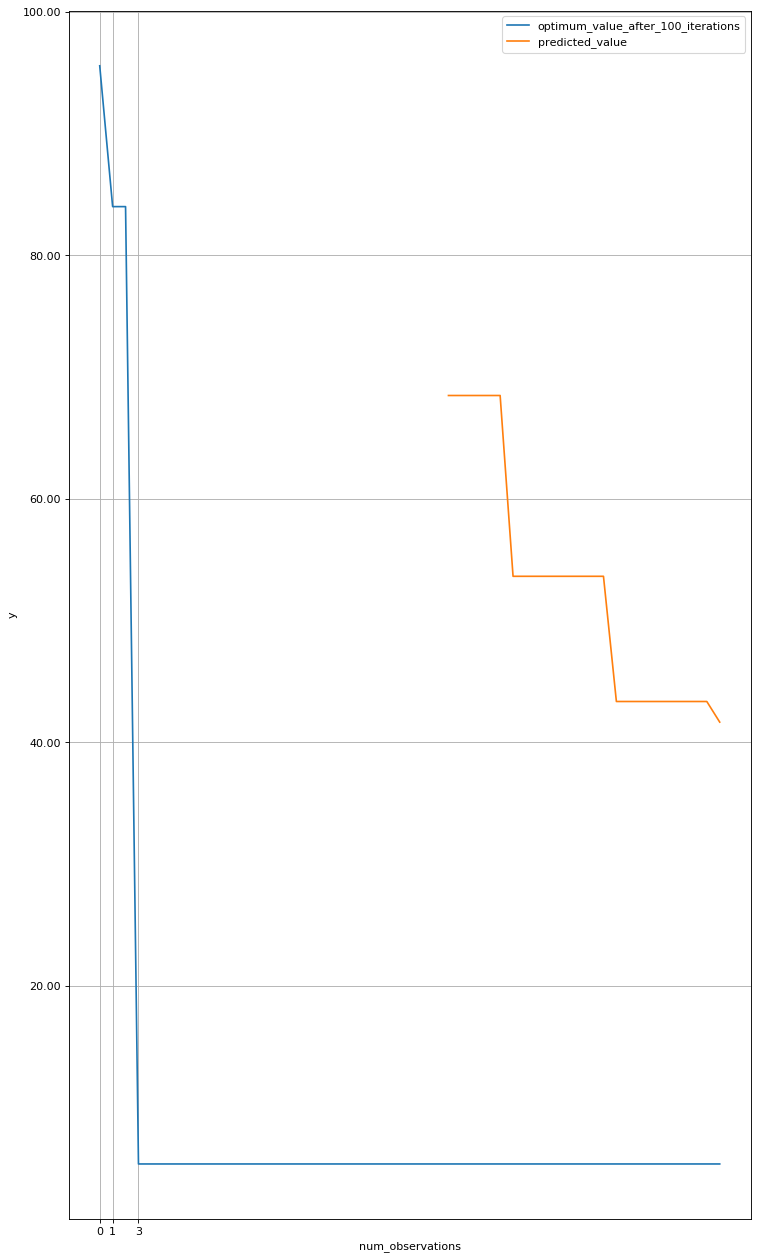

In [41]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline

fig, axs = plt.subplots(1, figsize=(11, 20), dpi=80, sharex=True)

axs.plot(best_observation_df['num_observations'], best_observation_df['optimum_value_after_100_iterations'], label='optimum_value_after_100_iterations')
axs.plot(best_predicted_value_df['num_observations'], best_predicted_value_df['predicted_value'], label='predicted_value')
axs.set_ylabel('y')
axs.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
axs.set_xticks(best_observation_df['num_observations'][::2])
axs.grid(True)
axs.set_xlabel('num_observations')
axs.legend()  
fig.show()

In [42]:
from mlos.Optimizers.RegressionModels.GoodnessOfFitMetrics import DataSetType

# Let's take a look at goodness of fit data.
#
goodness_of_fit_dataframe = regression_model_fit_state.get_goodness_of_fit_dataframe(data_set_type=DataSetType.TRAIN) # TODO: add support to evaluate GoF on test data

C:\Users\adsmiech\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


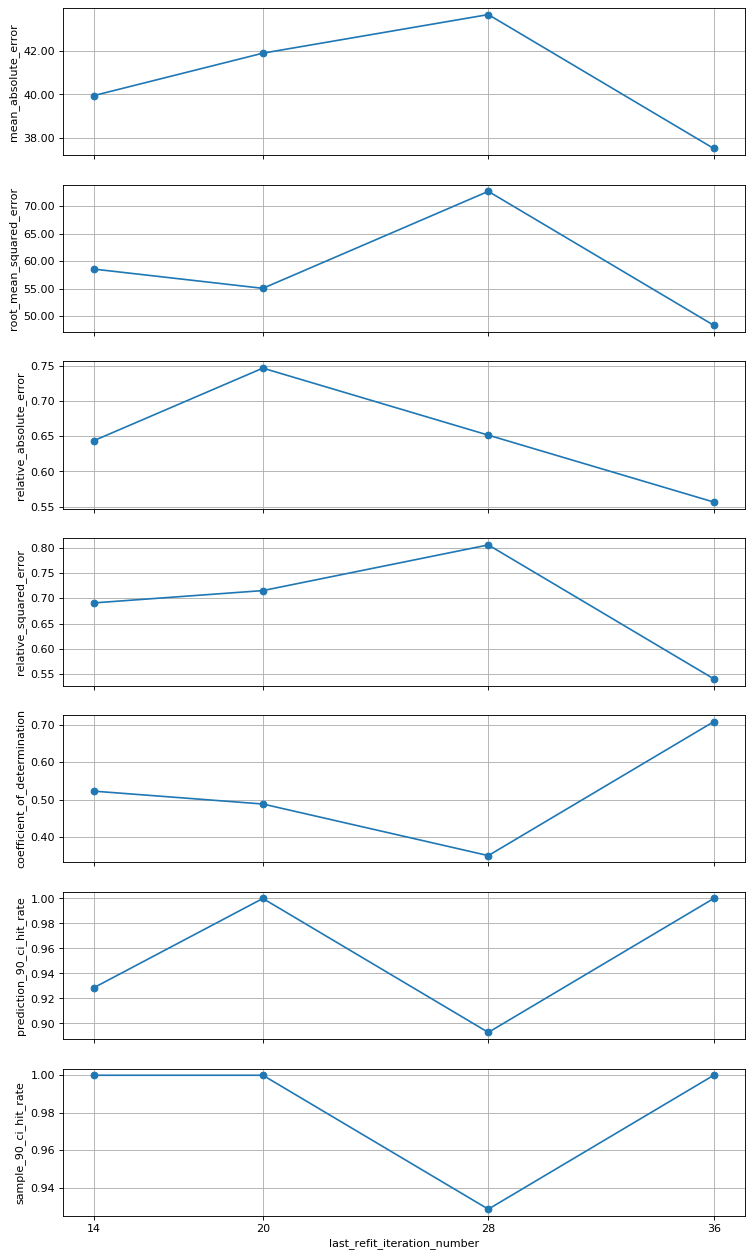

In [43]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline

gof_df = goodness_of_fit_dataframe
columns_to_plot = [name for name in gof_df.columns.values if name not in ('observation_count', 'prediction_count', 'last_refit_iteration_number')]
num_plots = len(columns_to_plot)
fig, axs = plt.subplots(num_plots, figsize=(11, 20), dpi=80, sharex=True)

for i, column in enumerate(columns_to_plot):
    axs[i].plot(gof_df['last_refit_iteration_number'], gof_df[column], marker='o', label=column)
    axs[i].set_ylabel(column)
    axs[i].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
    axs[i].set_xticks(gof_df['last_refit_iteration_number'])
    axs[i].grid(True)
    if i == num_plots - 1:
        axs[i].set_xlabel('last_refit_iteration_number')
        
fig.show()

In [34]:
global_values.tracer.dump_trace_to_file(r"E:\code\new_mlos\source\Mlos.Python\temp\meta_optimizer.json")